##### Purpose of the notebook ####

Explore gene modules present within different cell types, defining subtypes. In this case: oligodendrocytes.

In [1]:
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt
import warnings
import pandas as pd

In [2]:
path='/media/sergio/Ymir/5k_ovarian/'

In [3]:
adata=sc.read_10x_h5(path+'cell_feature_matrix.h5')

In [4]:
cellinfo=pd.read_parquet(path+'cells.parquet')

In [5]:
adata.obs=cellinfo

In [6]:
dat = cnv.datasets.maynard2020_3k()
dat.var.loc[:, ["ensg", "chromosome", "start", "end"]].head()

,ensg,chromosome,start,end
symbol,,,,
AL645933.5,ENSG00000288587.1,chr6,31400702,31463705
AC010184.1,ENSG00000288585.1,chr3,141449745,141456434
AC023296.1,ENSG00000288580.1,chr8,2923568,2926689
AL117334.2,ENSG00000288577.1,chr20,3406380,3410036
AC107294.4,ENSG00000288576.1,chr3,184778723,184780720


In [7]:
adata=adata[:,adata.var.index.isin(dat.var['gene_name'])]

In [8]:
name2gid=dict(zip(dat.var['gene_name'],dat.var['gene_id']))
name2symbol=dict(zip(dat.var['gene_name'],dat.var.index))

In [9]:
adata.var['gene_id']=adata.var.index.map(name2gid)
adata.var['symbol']=adata.var.index.map(name2symbol)

/tmp/ipykernel_3509004/4285209568.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['gene_id']=adata.var.index.map(name2gid)
/home/sergio/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [10]:
name2ensg=dict(zip(dat.var['gene_name'],dat.var['ensg']))
name2chromosome=dict(zip(dat.var['gene_name'],dat.var['chromosome']))
name2start=dict(zip(dat.var['gene_name'],dat.var['start']))
name2end=dict(zip(dat.var['gene_name'],dat.var['end']))

In [11]:
adata.var['ensg']=adata.var.index.map(name2ensg)
adata.var['chromosome']=adata.var.index.map(name2chromosome)
adata.var['start']=adata.var.index.map(name2start)
adata.var['end']=adata.var.index.map(name2end)

In [12]:
sc.pp.subsample(adata,0.05)

In [13]:
import warnings
import numpy as np
from scipy.sparse import csr_matrix, issparse
from scvelo import logging as logg
from scvelo import settings
from scvelo.preprocessing.neighbors import get_connectivities, get_n_neighs, neighbors, verify_neighbors
from scvelo.preprocessing.utils import normalize_per_cell, not_yet_normalized


def moments(
    data,
    n_neighbors=30,
    n_pcs=None,
    mode="connectivities",
    method="umap",
    use_rep=None,
    use_highly_variable=True,
    copy=False,
):
    """Computes moments for velocity estimation.

    First-/second-order moments are computed for each cell across its nearest neighbors,
    where the neighbor graph is obtained from euclidean distances in PCA space.

    Arguments:
    ---------
    data: :class:`~anndata.AnnData`
        Annotated data matrix.
    n_neighbors: `int` (default: 30)
        Number of neighbors to use.
    n_pcs: `int` (default: None)
        Number of principal components to use.
        If not specified, the full space is used of a pre-computed PCA,
        or 30 components are used when PCA is computed internally.
    mode: `'connectivities'` or `'distances'`  (default: `'connectivities'`)
        Distance metric to use for moment computation.
    method : {{'umap', 'hnsw', 'sklearn', `None`}}  (default: `'umap'`)
        Method to compute neighbors, only differs in runtime.
        Connectivities are computed with adaptive kernel width as proposed in
        Haghverdi et al. 2016 (https://doi.org/10.1038/nmeth.3971).
    use_rep : `None`, `'X'` or any key for `.obsm` (default: None)
        Use the indicated representation. If `None`, the representation is chosen
        automatically: for .n_vars < 50, .X is used, otherwise ‘X_pca’ is used.
    use_highly_variable: `bool` (default: True)
        Whether to use highly variable genes only, stored in .var['highly_variable'].
    copy: `bool` (default: `False`)
        Return a copy instead of writing to adata.

    Returns
    -------
    Ms: `.layers`
        dense matrix with first order moments of spliced counts.
    Mu: `.layers`
        dense matrix with first order moments of unspliced counts.
    """
    adata = data.copy() if copy else data

    layers = [layer for layer in {"raw"} if layer in adata.layers]
    if any([not_yet_normalized(adata.layers[layer]) for layer in layers]):
        normalize_per_cell(adata)

    if n_neighbors is not None and n_neighbors > get_n_neighs(adata):
        warnings.warn(
            "Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version "
            "of scVelo. Please compute neighbors first with Scanpy.",
            DeprecationWarning,
            stacklevel=2,
        )
        neighbors(
            adata,
            n_neighbors=n_neighbors,
            use_rep=use_rep,
            use_highly_variable=use_highly_variable,
            n_pcs=n_pcs,
            method=method,
        )
    verify_neighbors(adata)

    if "spliced" not in adata.layers.keys() or "unspliced" not in adata.layers.keys():
        logg.info(f"computing moments based on {mode}", r=True)
        connectivities = get_connectivities(
            adata, mode, n_neighbors=n_neighbors, recurse_neighbors=False
        )
        adata.layers["Ms"] = (
            csr_matrix.dot(connectivities, csr_matrix(adata.layers["raw"]))
            .astype(np.float32)
            .toarray()
        )
    return adata if copy else None

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmp6dh4ie1u
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmp6dh4ie1u/_remote_module_non_scriptable.py
INFO:lightning_fabric.utilities.seed:Global seed set to 0


In [14]:
adata.layers['raw']=adata.X.copy()
moments(adata)

Normalized count data: X.


/tmp/ipykernel_3509004/2454819030.py:2: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  moments(adata)
/tmp/ipykernel_3509004/3457130136.py:69: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(
/home/sergio/.local/lib/python3.8/site-packages/scvelo/preprocessing/neighbors.py:233: DeprecationWarning: Automatic computation of PCA is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute PCA with Scanpy first.
  _set_pca(adata=adata, n_pcs=n_pcs, use_highly_variable=use_highly_variable)


computing neighbors


2024-10-03 16:04:47.893595: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


    finished (0:00:30) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities


In [15]:
adata.X=adata.layers['Ms']

In [16]:
sc.pp.filter_cells(adata,min_counts=10)
sc.pp.normalize_total(adata)

In [17]:
sc.pp.log1p(adata)

In [18]:
sc.pp.pca(adata)

In [19]:
sc.pp.neighbors(adata,n_pcs=50)

In [20]:
sc.tl.leiden(adata,resolution=0.5)

In [21]:
sc.tl.umap(adata)

... storing 'segmentation_method' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'chromosome' as categorical
/home/sergio/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


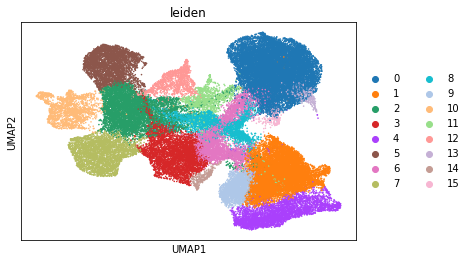

In [22]:
sc.pl.umap(adata,color='leiden',s=10)

In [23]:
import numpy as np
adata.obsm['spatial']=np.array(adata.obs.loc[:,['x_centroid','y_centroid']])

/home/sergio/.local/lib/python3.8/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/home/sergio/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


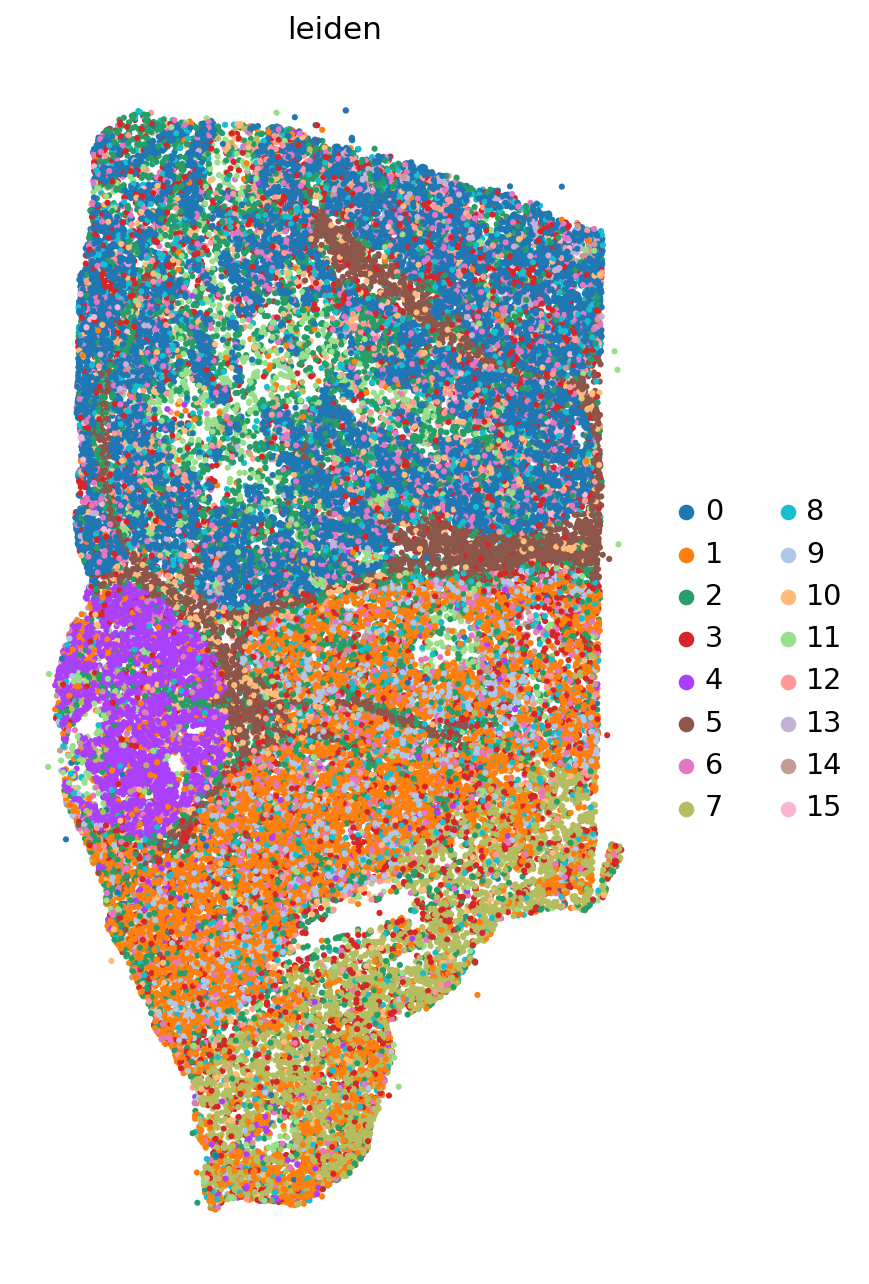

In [24]:
sc.settings.set_figure_params(figsize=(10, 10))
sc.pl.spatial(adata,color='leiden',spot_size=120,frameon=False)

In [25]:
sc.tl.rank_genes_groups(adata,groupby='leiden')

/home/sergio/.local/lib/python3.8/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


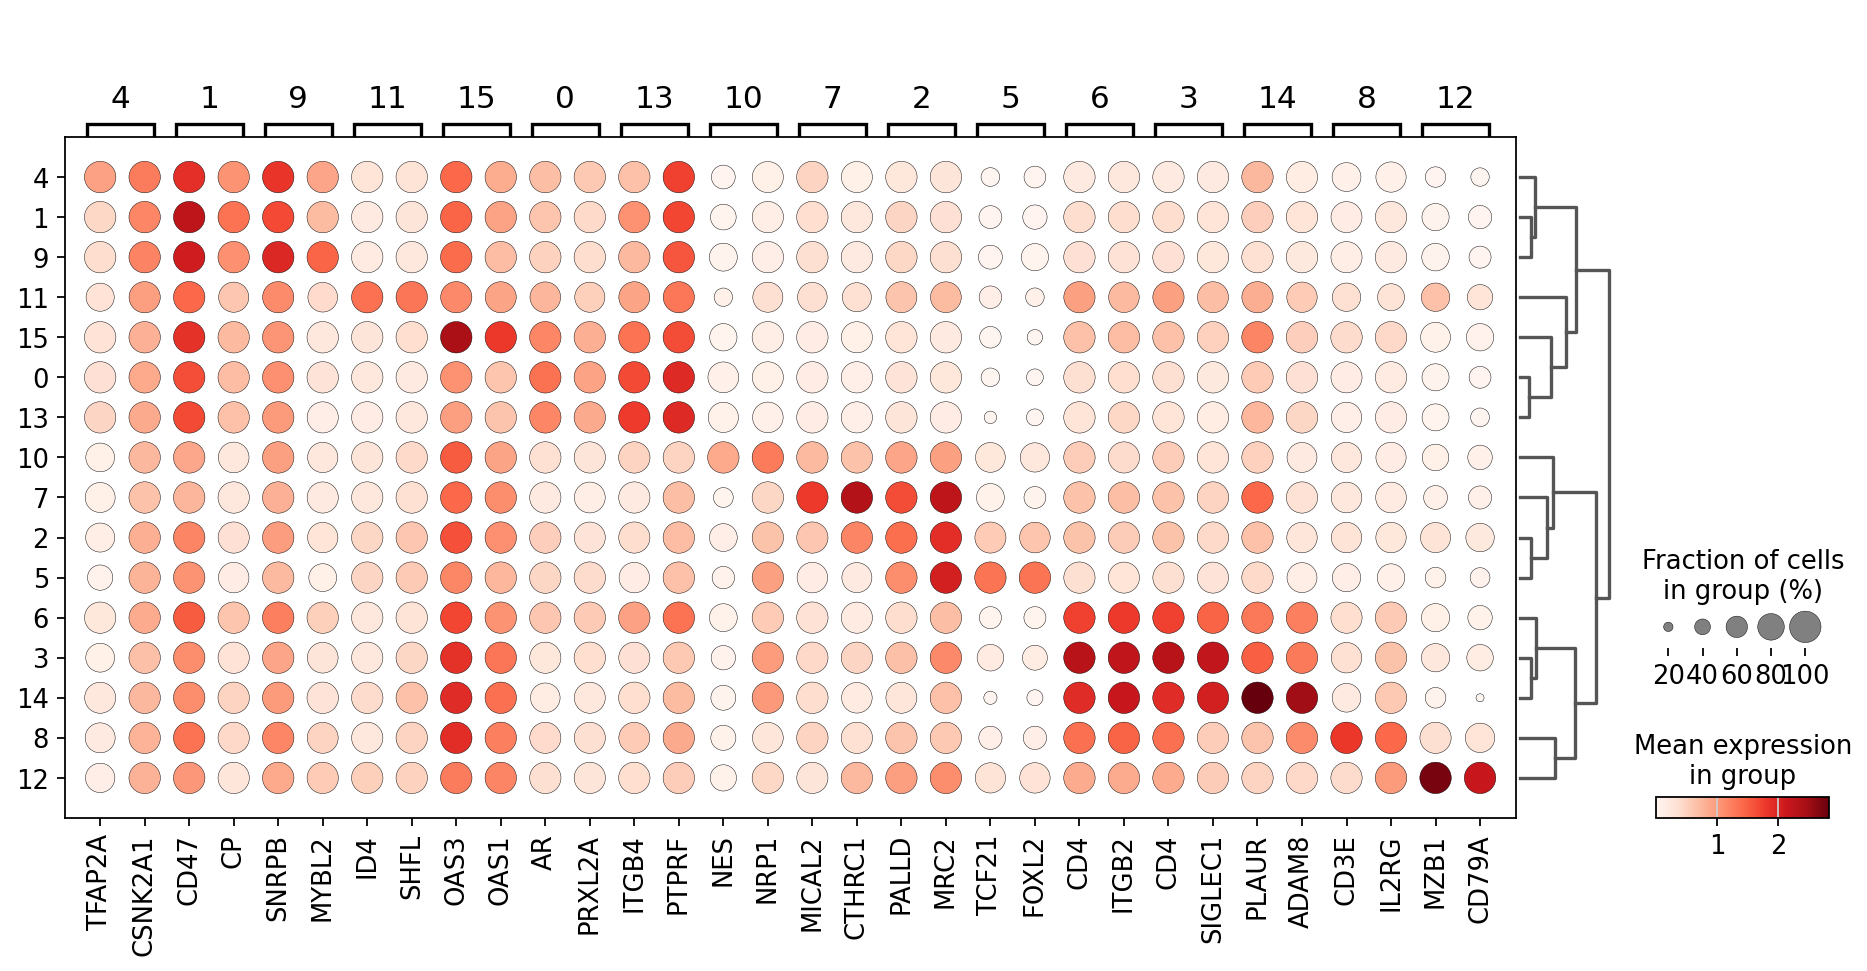

In [26]:
sc.settings.set_figure_params(figsize=(7, 7))
sc.pl.rank_genes_groups_dotplot(adata,n_genes=2)

In [28]:
cnv.tl.infercnv(adata, reference_key="leiden", reference_cat=['12','5','6'], window_size=60,layer='Ms')

  0%|          | 0/12 [00:00<?, ?it/s]

In [29]:
sc.tl.dendrogram(adata,groupby='leiden')

categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


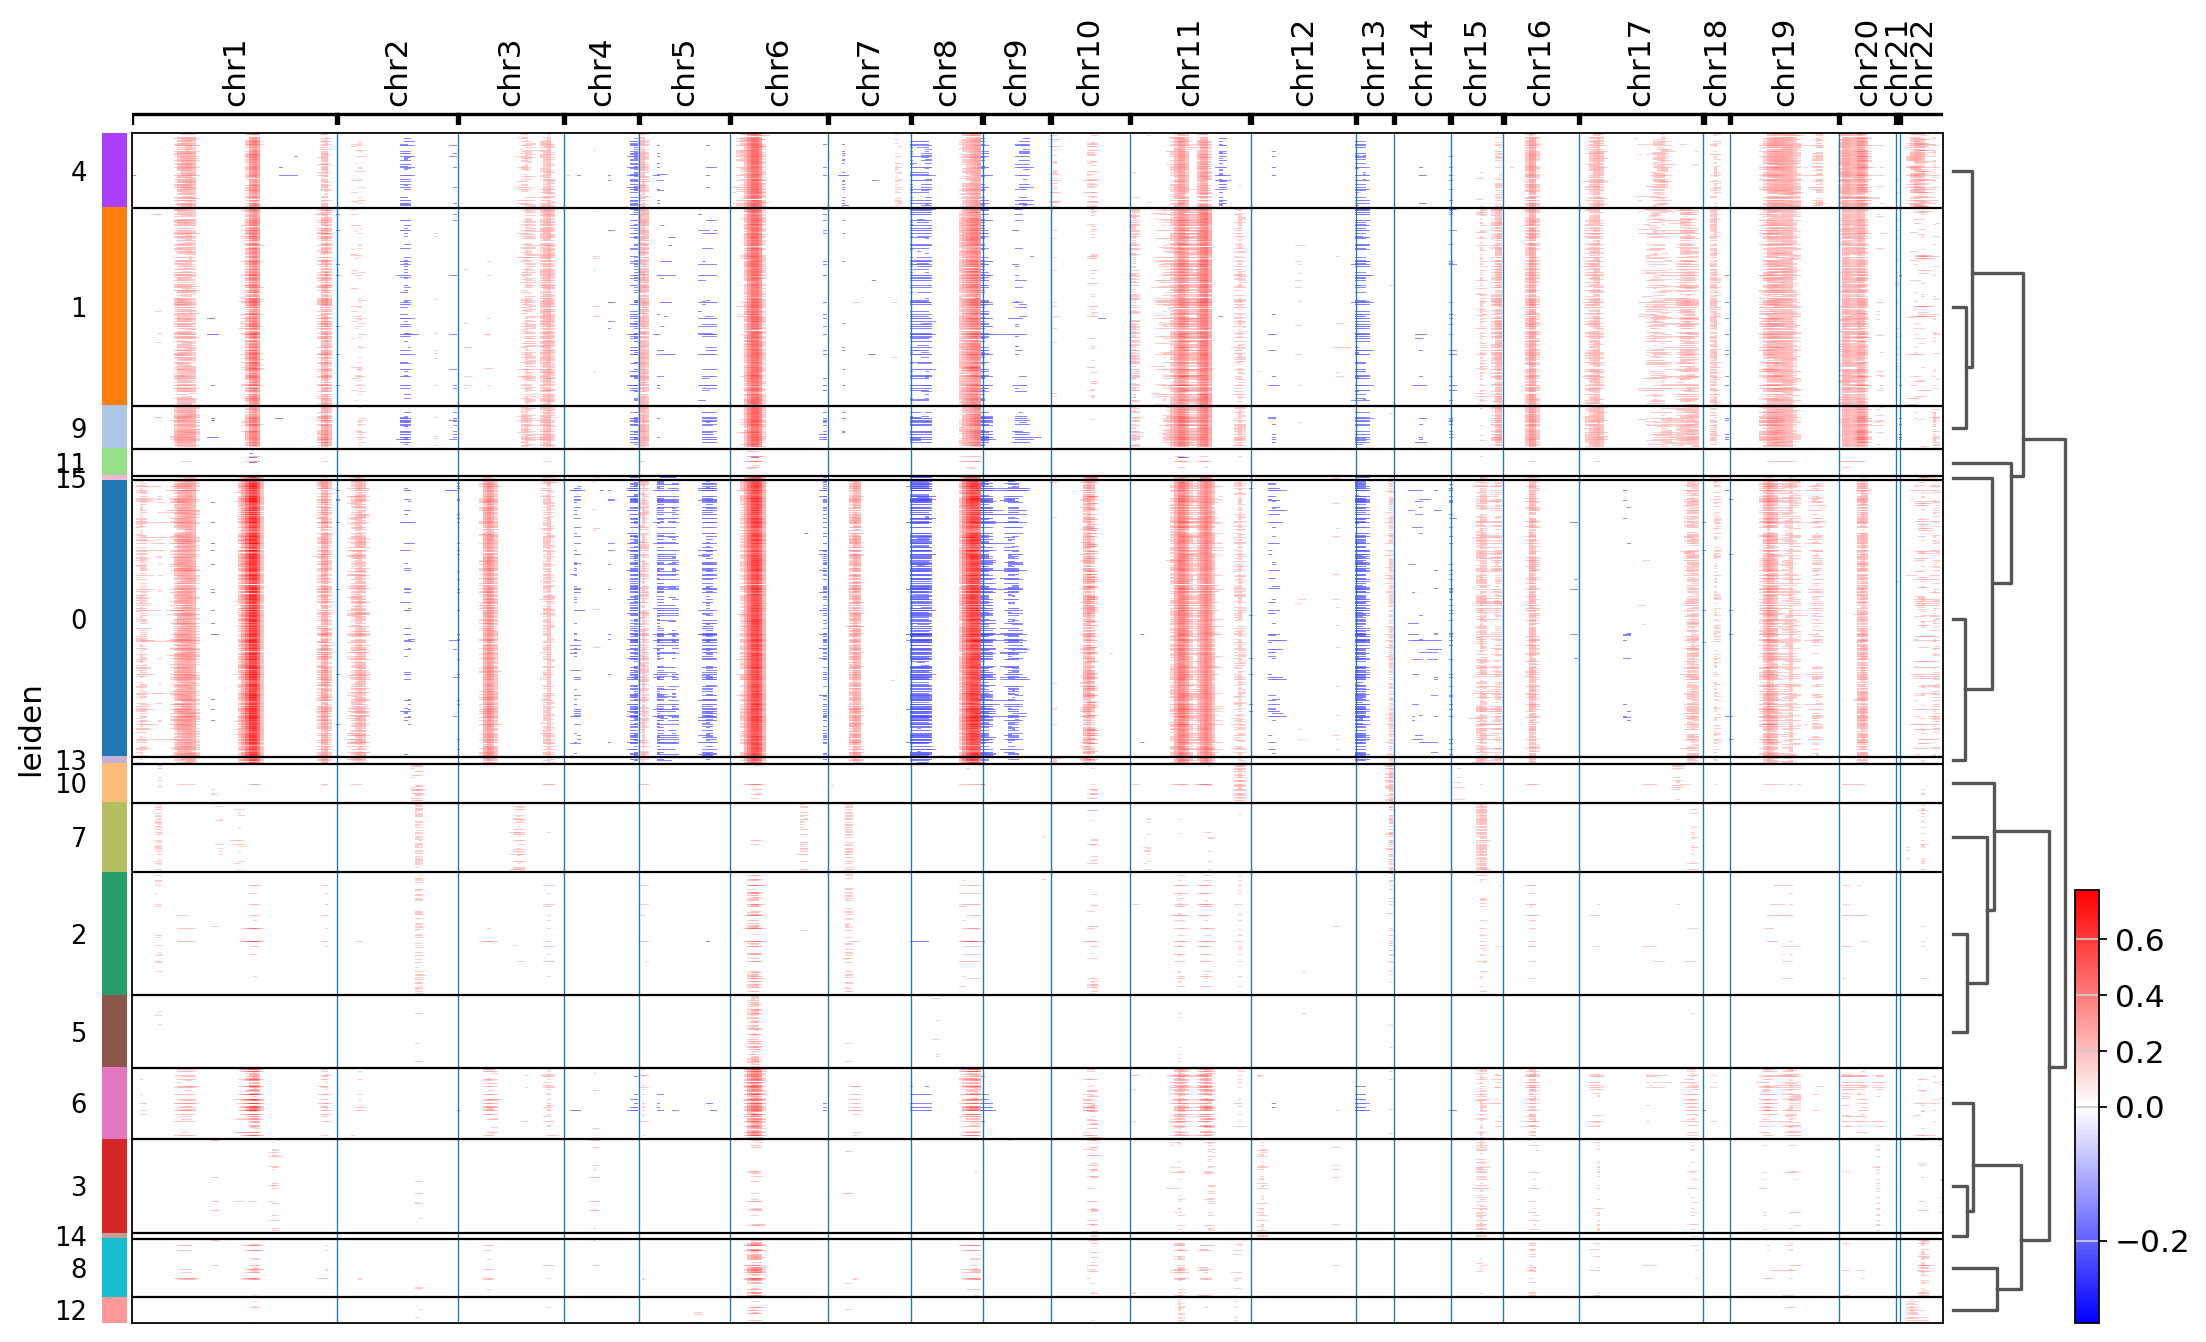

In [31]:
cnv.pl.chromosome_heatmap(adata, groupby="leiden", dendrogram=True)

In [47]:
#adata.write('/media/sergio/Meninges/CosMx-WTx/WTx-CosMx/raw-B-1970164-01-04_2/adata_1970164_processed.h5ad')

In [32]:
adata

AnnData object with n_obs × n_vars = 57882 × 4993
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_id', 'symbol', 'ensg', 'chromosome', 'start', 'end', 'gene_count_corr'
    uns: 'pca', 'neighbors', 'log1p', 'leiden', 'umap', 'leiden_colors', 'rank_genes_groups', 'dendrogram_leiden', 'cnv'
    obsm: 'X_pca', 'X_umap', 'spatial', 'X_cnv'
    varm: 'PCs'
    layers: 'raw', 'Ms'
    obsp: 'distances', 'connectivities'

In [33]:
cnv.tl.pca(adata)
cnv.pp.neighbors(adata,n_pcs=30)

In [41]:
cnv.tl.leiden(adata,resolution=0.01)

/home/sergio/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


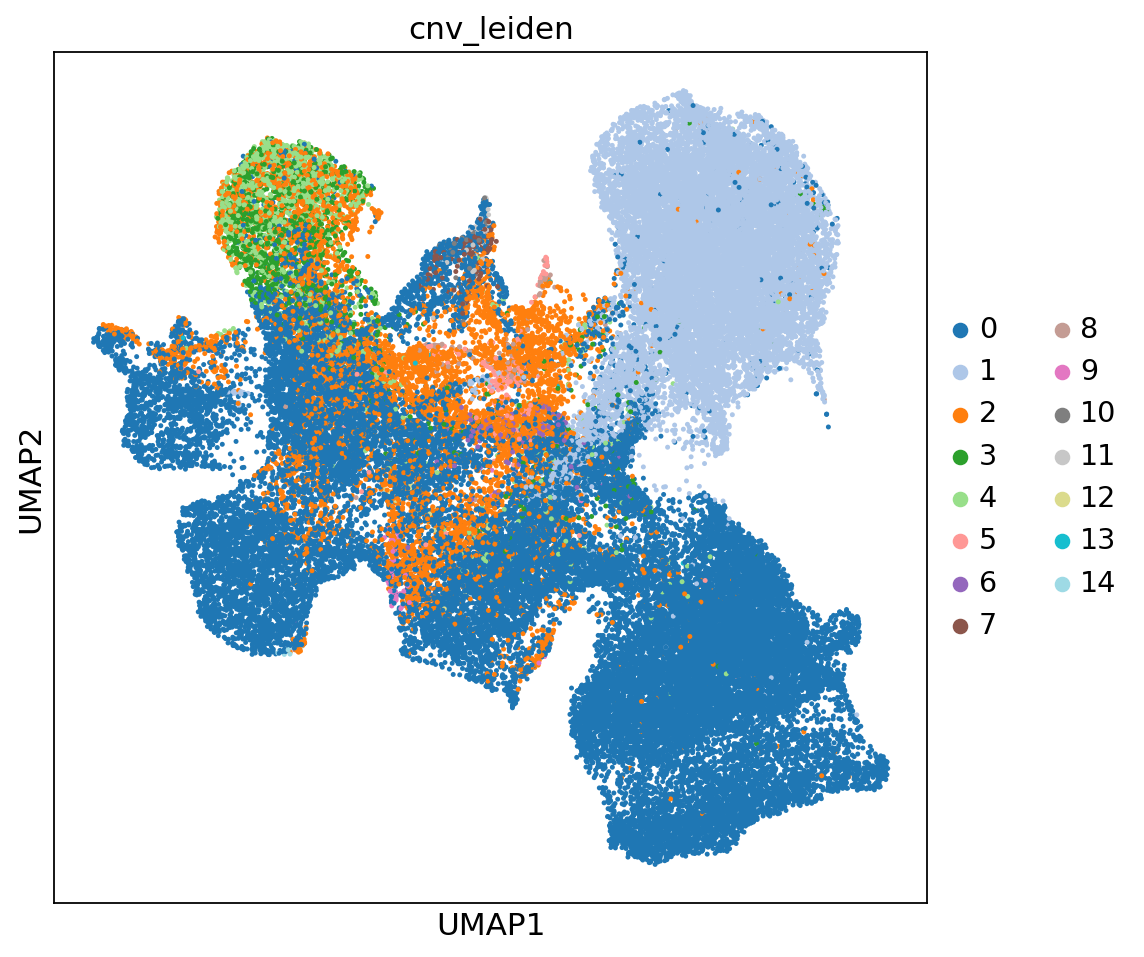

In [43]:
sc.pl.umap(adata,color='cnv_leiden',s=20,palette='tab20')

/home/sergio/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


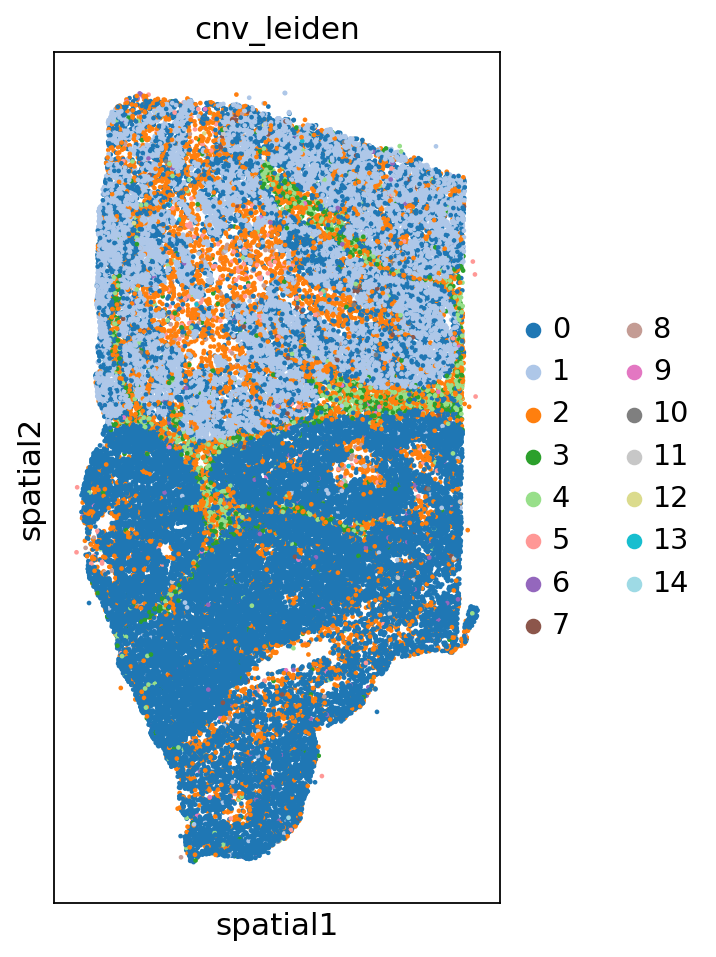

In [44]:
sc.pl.spatial(adata,color='cnv_leiden',spot_size=130)

In [37]:
sc.tl.dendrogram(adata,groupby='cnv_leiden')

categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


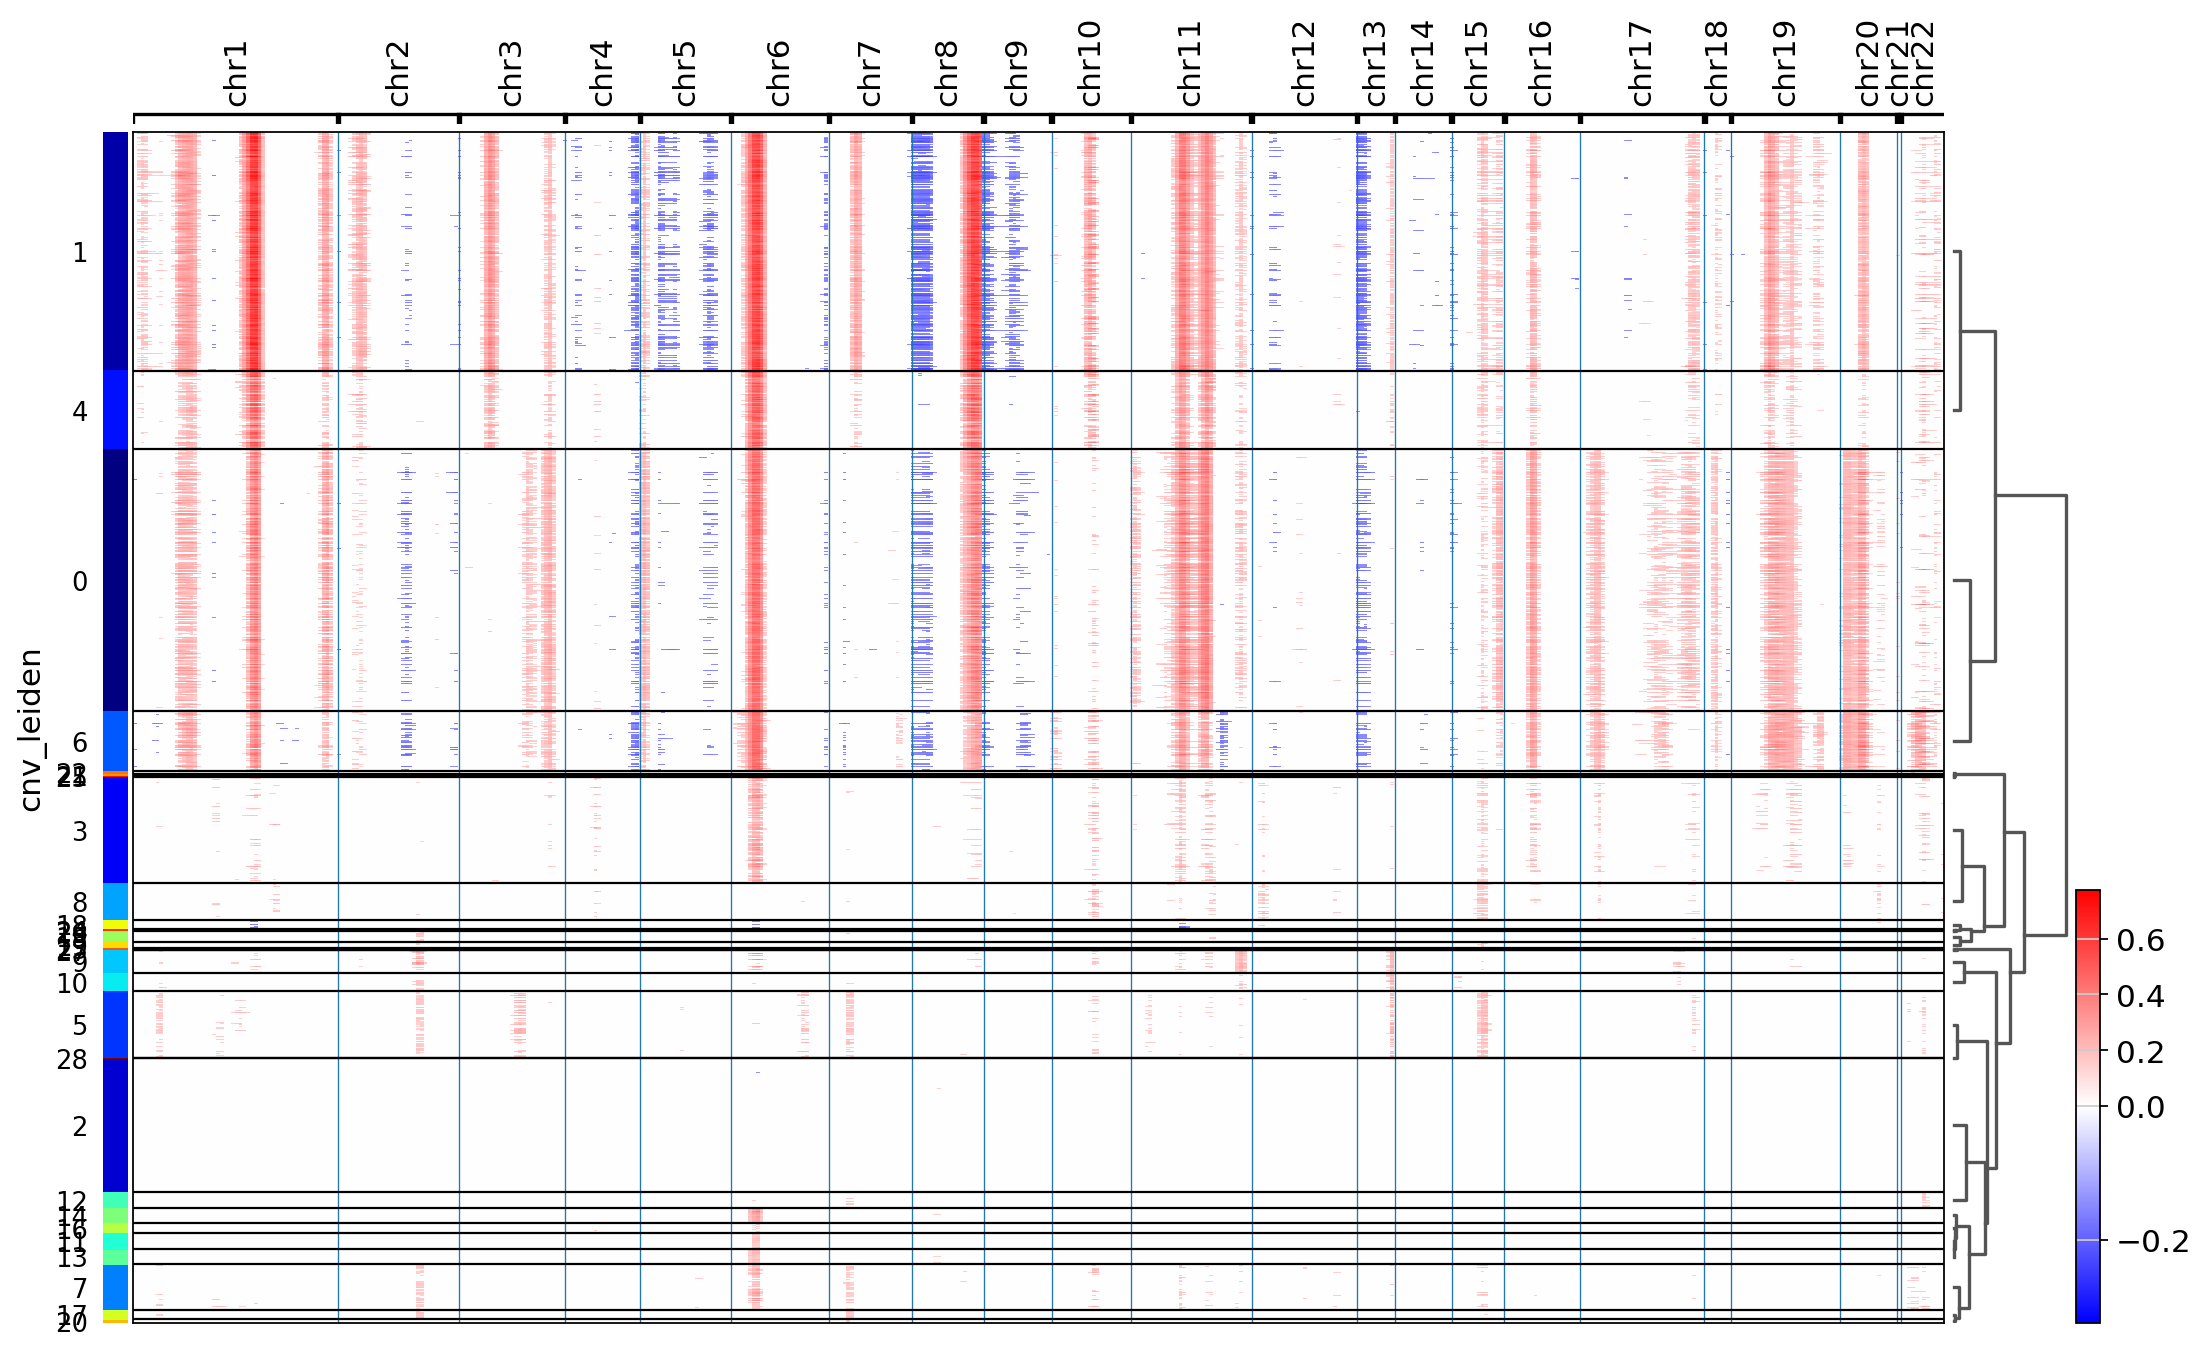

In [38]:
cnv.pl.chromosome_heatmap(adata, groupby="cnv_leiden", dendrogram=True)